In [82]:
import os
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import geopandas as gpd

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.spatial import cKDTree

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

import warnings
warnings.filterwarnings('ignore')

## Create a ENSEMBLE and export as Netcdf

In [2]:
yy_s, yy_e = 2002, 2023
years_num = yy_e - yy_s + 1

npix = 2
acf = 'mar'
cor = 'pearson'

In [61]:
veneto_dir = os.path.join('/','media','arturo','T9','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
    ITALY = gpd.read_file(os.path.join(veneto_dir,'Italy_clear.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [4]:
dir_base = os.path.join('/','media','arturo','T9','Data','Italy','Satellite','5_DOWN')

In [5]:
# CMORPH data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_CMORPH_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}_corrected.nc')
DATA_CM = xr.open_dataset(data_dir)

Tr = DATA_CM.Tr.values
print(f'Return period: {Tr[3]}')

lon2d_CM, lat2d_CM = np.meshgrid(DATA_CM.lon.values, DATA_CM.lat.values)

Return period: 50


In [6]:
# ERA5 data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_ERA5_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_ER = xr.open_dataset(data_dir)

lon2d_ER, lat2d_ER = np.meshgrid(DATA_ER.lon.values, DATA_ER.lat.values)

In [7]:
## GSMaP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_GSMaP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_GS = xr.open_dataset(data_dir)

lon2d_GS, lat2d_GS = np.meshgrid(DATA_GS.lon.values, DATA_GS.lat.values)

In [8]:
# MSWEP data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_MSWEP_3h_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_MS = xr.open_dataset(data_dir)

lon2d_MS, lat2d_MS = np.meshgrid(DATA_MS.lon.values, DATA_MS.lat.values)

In [9]:
# IMERG data
data_dir = os.path.join(dir_base, f'ITALY_DOWN_IMERG_1dy_{yy_s}_{yy_e}_npix_{npix}_thr_1_acf_{acf}_genetic_{cor}.nc')
DATA_IM = xr.open_dataset(data_dir)
lat_IM = DATA_IM.lat.values
lon_IM = DATA_IM.lon.values

lon2d_IM, lat2d_IM = np.meshgrid(DATA_IM.lon.values, DATA_IM.lat.values)

In [10]:
def get_nearest_values(ref_lat2d, ref_lon2d, target_lat2d, target_lon2d, target_data):
    """
    Para cada punto en la malla de referencia, busca el valor más cercano en la malla objetivo.
    """
    ny, nx = ref_lat2d.shape
    ref_points = np.column_stack((ref_lat2d.ravel(), ref_lon2d.ravel()))
    target_points = np.column_stack((target_lat2d.ravel(), target_lon2d.ravel()))
    tree = cKDTree(target_points)
    _, idx = tree.query(ref_points)
    matched_values = target_data.ravel()[idx]
    return matched_values.reshape(ny, nx)

In [11]:
n_ret = DATA_IM.Mev_d.shape[0]  # número de tiempos de retorno, probablemente 6

# Inicializar arrays vacíos para los productos remuestreados
MS_remapped = np.full((n_ret, *lat2d_IM.shape), np.nan)
GS_remapped = np.full_like(MS_remapped, np.nan)
ER_remapped = np.full_like(MS_remapped, np.nan)
CM_remapped = np.full_like(MS_remapped, np.nan)
IM_data     = np.full_like(MS_remapped, np.nan)

# Llenar por cada tiempo de retorno
for i in range(n_ret):
    # Extraer el mapa para ese retorno
    IM_Mevd = DATA_IM.Mev_d.values[i, :, :]
    MS_Mevd = DATA_MS.Mev_d.values[i, :, :]
    GS_Mevd = DATA_GS.Mev_d.values[i, :, :]
    ER_Mevd = DATA_ER.Mev_d.values[i, :, :]
    CM_Mevd = DATA_CM.Mev_d.values[i, :, :]

    # Vecinos más cercanos para este tiempo de retorno
    MS_nearest = get_nearest_values(lat2d_IM, lon2d_IM, lat2d_MS, lon2d_MS, MS_Mevd)
    GS_nearest = get_nearest_values(lat2d_IM, lon2d_IM, lat2d_GS, lon2d_GS, GS_Mevd)
    ER_nearest = get_nearest_values(lat2d_IM, lon2d_IM, lat2d_ER, lon2d_ER, ER_Mevd)
    CM_nearest = get_nearest_values(lat2d_IM, lon2d_IM, lat2d_CM, lon2d_CM, CM_Mevd)

    # Guardar los datos remuestreados
    IM_data[i, :, :]     = IM_Mevd
    MS_remapped[i, :, :] = MS_nearest
    GS_remapped[i, :, :] = GS_nearest
    ER_remapped[i, :, :] = ER_nearest
    CM_remapped[i, :, :] = CM_nearest

# Stack final
stacked_all = np.stack([IM_data, MS_remapped, GS_remapped, ER_remapped, CM_remapped], axis=0)

# Calcular ensemble
Mevd_ensemble_mean   = np.nanmean(stacked_all, axis=0)  # shape: (n_ret, ny, nx)
Mevd_ensemble_median = np.nanmedian(stacked_all, axis=0)

In [12]:
Med_min = min(np.nanmin(Mevd_ensemble_mean[:,:,:]), np.nanmin(Mevd_ensemble_median[:,:,:]))
Med_max = max(np.nanmax(Mevd_ensemble_mean[:,:,:]), np.nanmax(Mevd_ensemble_median[:,:,:]))

Med_min = 10*(np.round(np.floor(Med_min)/10))
Med_max = 10*(np.round(np.ceil(Med_max)/10))

print(f"Med_min: {int(Med_min)}, Med_max: {int(Med_max)}")
Med_range = np.arange(int(Med_min), int(Med_max)+10, 10)

Med_min: 40, Med_max: 360


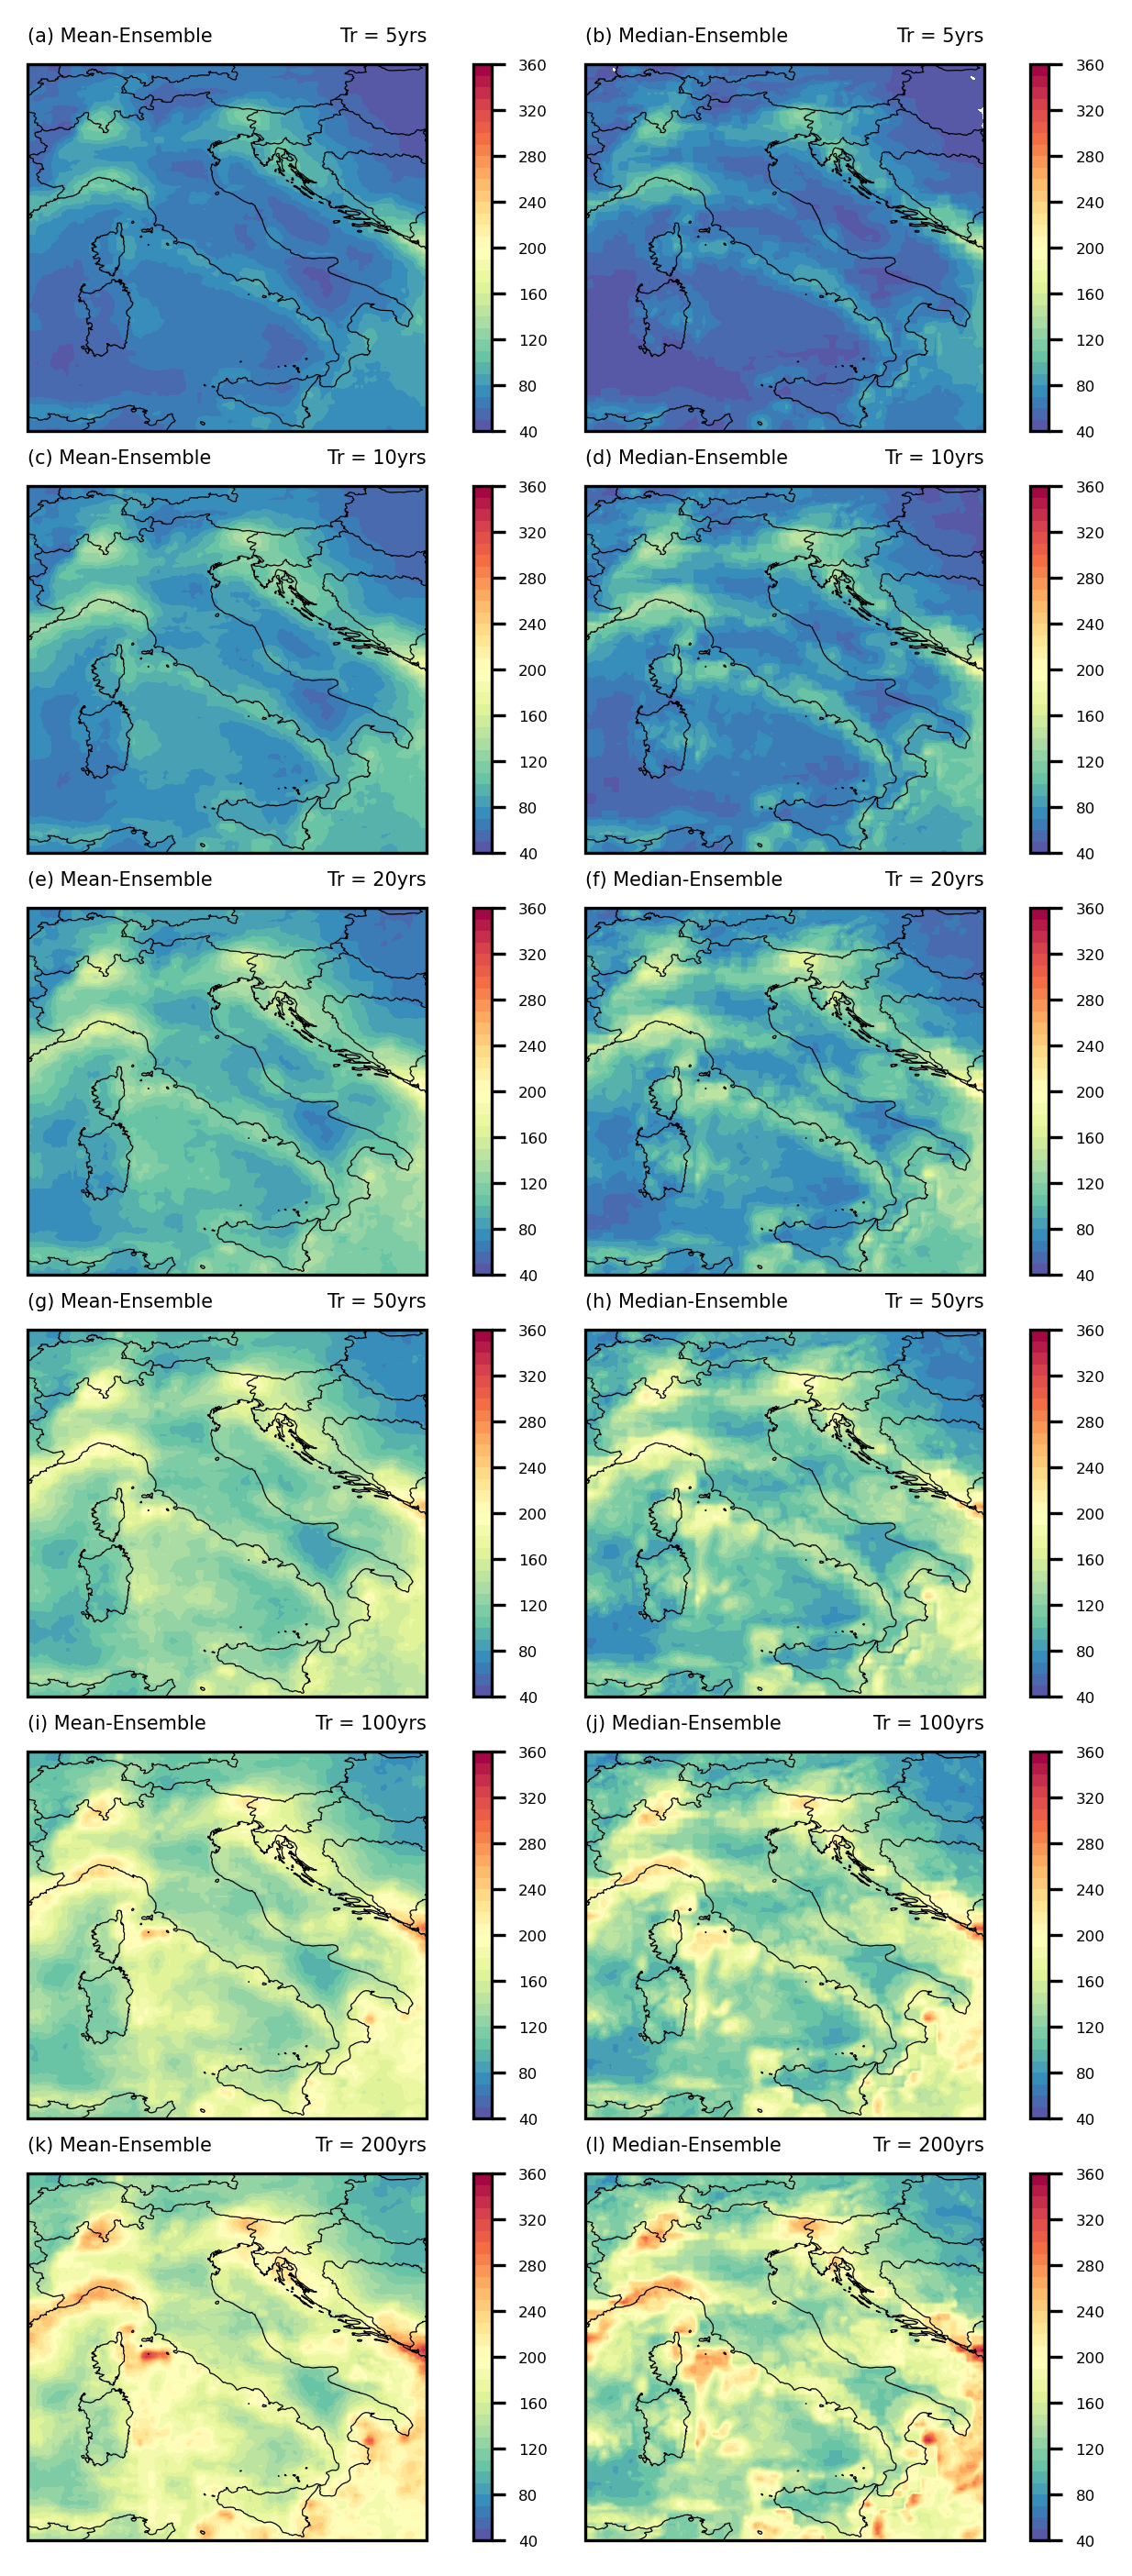

In [13]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(6,10),dpi=300)
gs = gridspec.GridSpec(6,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[0,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[0]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[0,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[0]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[1, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[1,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(c) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[1]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[1, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[1,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(d) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[1]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[2, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[2,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(e) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[2]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[2, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[2,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(f) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[2]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[3, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[3,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(g) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[3]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[3, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[3,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(h) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[3]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[4, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[4,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(i) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[4]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[4, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[4,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(j) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[4]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[5, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[5,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(k) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[5]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[5, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[5,:,:], cmap=cmap, levels=Med_range)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(l) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[5]}yrs', fontsize=5, loc='right')

# ==============================================================================
# ==============================================================================
plt.subplots_adjust(left=0.05, bottom=0.05, right=0.95, top=0.95, wspace=-0.4, hspace=0.15)

In [14]:
index = 3

Text(1.0, 1.0, 'Tr = 50yrs')

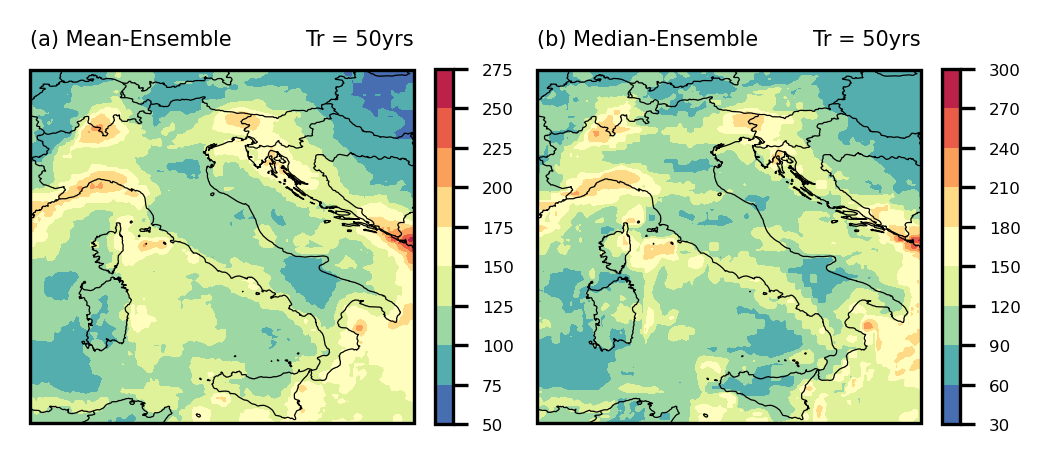

In [15]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,6),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[index]}yrs', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_median[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Median-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Tr = {Tr[index]}yrs', fontsize=5, loc='right')

## Manual method for compare 

In [16]:
ENSEMBLE_manual = np.zeros_like(DATA_IM.Mev_d.values)
for i in range(len(lat_IM)):
    for j in range(len(lon_IM)):
        IM_vector = DATA_IM.Mev_d.values[:,i,j]
        
        distances = ART_pre.haversine(lat2d_CM, lon2d_CM, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        CM_vector = DATA_CM.Mev_d.values[:,min_index[0],min_index[1]]
        
        distances = ART_pre.haversine(lat2d_ER, lon2d_ER, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        ER_vector = DATA_ER.Mev_d.values[:,min_index[0],min_index[1]]
        
        distances = ART_pre.haversine(lat2d_GS, lon2d_GS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        GS_vector = DATA_GS.Mev_d.values[:,min_index[0],min_index[1]]
        
        distances = ART_pre.haversine(lat2d_MS, lon2d_MS, lat_IM[i], lon_IM[j])
        min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)
        MS_vector = DATA_MS.Mev_d.values[:,min_index[0],min_index[1]]
        
        ENSEMBLE_manual[:,i,j] = np.nanmean([IM_vector, CM_vector, ER_vector, GS_vector, MS_vector], axis=0)

Text(1.0, 1.0, 'Manual')

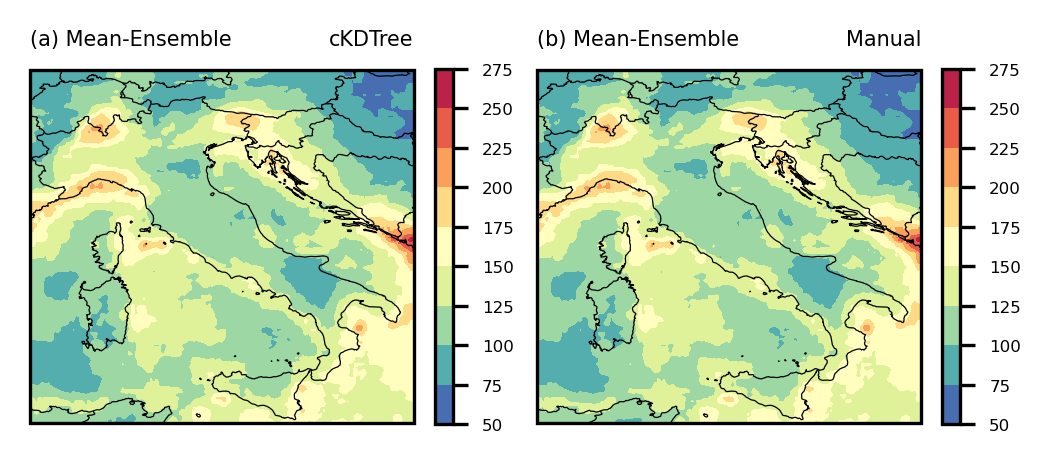

In [17]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,6),dpi=300)
gs = gridspec.GridSpec(1,2)

# ==============================================================================
# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, Mevd_ensemble_mean[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(a) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'cKDTree', fontsize=5, loc='right')

# ==============================================================================
ax1 = plt.subplot(gs[0, 1], projection = proj)
ax1.add_feature(cfeature.COASTLINE,linewidth=0.3,color='black',zorder=4)
ax1.add_feature(cfeature.BORDERS,linewidth=0.3,color='black',zorder=4)
a1 = ax1.contourf(lon2d_IM, lat2d_IM, ENSEMBLE_manual[index,:,:], cmap=cmap, levels=None)
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, fraction=0.042)
cbar.ax.tick_params(labelsize=4)
ax1.set_title('(b) Mean-Ensemble', fontsize=5, loc='left')
ax1.set_title(f'Manual', fontsize=5, loc='right')

## Compare ENSEMBLE with rain gauges

In [46]:
yy_s, yy_e = 2002, 2022
years_num = yy_e - yy_s + 1

In [47]:
obs_base = os.path.join('/','media','arturo','T9','Data','Italy')

In [48]:
OBS_base = os.path.join(obs_base,'stations','data')
OBS_INFO_dir = os.path.join(os.path.join(OBS_base),'Weibull','Veneto_INFO.csv')

if os.path.exists(OBS_INFO_dir):
    wa_pd = pd.read_csv(OBS_INFO_dir, sep=',')
else:
    raise SystemExit(f"File not found: {OBS_INFO_dir}")
print(len(wa_pd))

255


In [49]:
total_years = np.arange(1980,2024)
print(f'Quantiles for period: {1980} to {2024}')
N_array = np.zeros([len(wa_pd),len(total_years)])
C_array = np.zeros([len(wa_pd),len(total_years)])
W_array = np.zeros([len(wa_pd),len(total_years)])

for nn in range(len(wa_pd)):
    filename = f'{wa_pd['File_Name'].values[nn]}.csv'
    Weibull_OBS = pd.read_csv(os.path.join(OBS_base,'Weibull','Veneto',filename))

    for count, YY in enumerate(total_years):
        N_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['N'].values
        C_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['C'].values
        W_ = Weibull_OBS[Weibull_OBS['Year'] == YY]['W'].values
        if len(N_) == 0:
            N_array[nn,count] = np.nan
            C_array[nn,count] = np.nan
            W_array[nn,count] = np.nan
        else:
            if N_[0] == 0:
                N_array[nn,count] = np.nan
                C_array[nn,count] = np.nan
                W_array[nn,count] = np.nan
            else:
                N_array[nn,count] = float(N_[0])
                C_array[nn,count] = float(C_[0])
                W_array[nn,count] = float(W_[0])

Quantiles for period: 1980 to 2024


In [50]:
print(f'Extract Parameters for: {yy_s} to {yy_e}')
N_df = pd.DataFrame(data=N_array,columns=total_years)
N_df = N_df.loc[:,yy_s:yy_e]
N_df.insert(0, 'filename', wa_pd['File_Name'].values)
N_df.insert(1, 'Lat', wa_pd['Lat'].values)
N_df.insert(2, 'Lon', wa_pd['Lon'].values)

C_df = pd.DataFrame(data=C_array,columns=total_years)
C_df = C_df.loc[:,yy_s:yy_e]
C_df.insert(0, 'filename', wa_pd['File_Name'].values)
C_df.insert(1, 'Lat', wa_pd['Lat'].values)
C_df.insert(2, 'Lon', wa_pd['Lon'].values)

W_df = pd.DataFrame(data=W_array,columns=total_years)
W_df = W_df.loc[:,yy_s:yy_e]
W_df.insert(0, 'filename', wa_pd['File_Name'].values)
W_df.insert(1, 'Lat', wa_pd['Lat'].values)
W_df.insert(2, 'Lon', wa_pd['Lon'].values)

print(len(W_df))

Extract Parameters for: 2002 to 2022
255


In [52]:
Tr = np.array([10, 20, 50, 100, 200])
Fi = 1 - 1/Tr
# Q_obs = np.zeros([len(wa_pd), len(Tr)])
Q_obs = []
File_, Lat_, Lon_, YYS_, YYE_, NY_ = [], [], [], [], [], []

count = 0
for nn in range(len(wa_pd)):
    N_ = N_df.loc[:,yy_s:yy_e].values[nn]
    C_ = C_df.loc[:,yy_s:yy_e].values[nn]
    W_ = W_df.loc[:,yy_s:yy_e].values[nn]

    if len(W_[~np.isnan(W_)]) >= years_num: # Number of years between yy_s to yy_e
        # print(nn,len(W_[~np.isnan(W_)]), len(W_))

        File_.append(wa_pd['File_Name'][nn])
        Lat_.append(wa_pd['Lat'][nn])
        Lon_.append(wa_pd['Lon'][nn])
        YYS_.append(yy_s)
        YYE_.append(yy_e)
        NY_.append(years_num - np.sum(np.isnan(N_)))

        x0 = np.nanmean(C_)
        TMP_Q, flags = ART_down.mev_quant_update(Fi, x0, N_, C_, W_, thresh=1)
        TMP_Q = np.where(flags==True,TMP_Q,np.nan)
        Q_obs.append(TMP_Q)

        count = count + 1

Q_obs_matrix = np.array(Q_obs)

new_df = pd.DataFrame(Q_obs_matrix, columns=['Q10','Q20','Q50','Q100','Q200'])
new_df.insert(0, 'File_Name', File_)
new_df.insert(1, 'Lat', Lat_)
new_df.insert(2, 'Lon', Lon_)
new_df.insert(3, 'YYS', YYS_)
new_df.insert(4, 'YYE', YYE_) 
new_df.insert(5, 'NY', NY_)

clear_df = new_df[new_df['NY']==years_num]
clear_df = new_df[new_df['NY'] == years_num].reset_index(drop=True)

print(len(clear_df))

169


In [53]:
frac = 0.8

Q_80 = clear_df.sample(frac=frac, random_state=42)
Q_80 = Q_80.reset_index(drop=True)

Q_20 = clear_df.drop(Q_80.index)
Q_20 = Q_20.reset_index(drop=True)

print(f'Number of Stations: {len(clear_df)}')
print(f'80% DataFrame: {len(Q_80)}')
print(f'20% DataFrame: {len(Q_20)}')

Number of Stations: 169
80% DataFrame: 135
20% DataFrame: 34


Text(1.0, 1.0, '2002 to 2022')

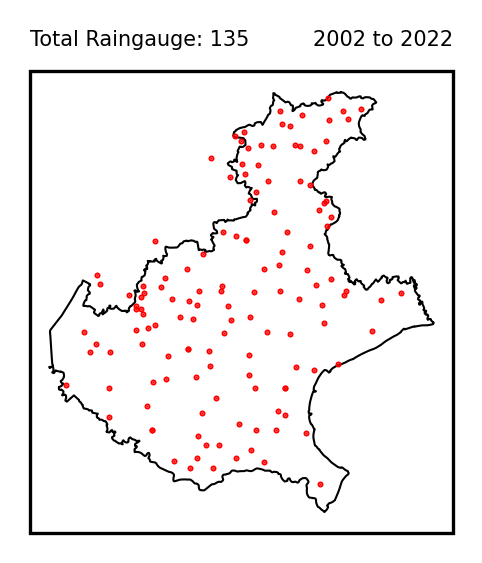

In [65]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(4,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ============================================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
VENETO.plot(facecolor='None', ax=ax1, linewidth=0.5, zorder=10)
ax1.scatter(Q_80['Lon'].values, Q_80['Lat'].values, s=0.2, c='r', zorder=20, label='Stations')
ax1.set_title(f'Total Raingauge: {len(Q_80)}', fontsize=5, loc='left')
ax1.set_title(f'{yy_s} to {yy_e}', fontsize=5, loc='right')

In [75]:
ENSEMBLE_MEAN_Qd, ENSEMBLE_MEDI_Qd = [], []
ENSEMBLE_lon, ENSEMBLE_lat = [], []

for nn in range(len(Q_80)):
    Q_OBS = Q_80['Q50'].values[nn]
    lat_obs = Q_80['Lat'].values[nn]
    lon_obs = Q_80['Lon'].values[nn]

    distances = ART_pre.haversine(lat2d_IM, lon2d_IM, lat_obs, lon_obs)
    min_index = np.unravel_index(np.argmin(distances, axis=None), distances.shape)

    ENSEMBLE_lat_ = lat_IM[min_index[0]]
    ENSEMBLE_lon_ = lon_IM[min_index[1]]
    ENSEMBLE_lat.append(float(ENSEMBLE_lat_))
    ENSEMBLE_lon.append(float(ENSEMBLE_lon_))

    ENSEMBLE_MEAN_Qd.append(float(Mevd_ensemble_mean[3,min_index[0],min_index[1]]))
    ENSEMBLE_MEDI_Qd.append(float(Mevd_ensemble_median[3,min_index[0],min_index[1]]))

In [79]:
DF_data = pd.DataFrame({
        'OBS_lat':Q_80['Lat'].values,
        'OBS_lon':Q_80['Lon'].values,
        'OBS_Q50':Q_80['Q50'].values,
        'ENSEMBLE_lat':ENSEMBLE_lat,
        'ENSEMBLE_lon':ENSEMBLE_lon,
        'ENSEMBLE_MEAN_Q50s':ENSEMBLE_MEAN_Qd,
        'ENSEMBLE_MEDI_Q50s':ENSEMBLE_MEDI_Qd,
        })

In [83]:
colors = ['royalblue','r', 'g', 'c', 'y', 'purple', 'orange', 'cyan']

In [84]:
IMERG_MEAN_QEs = (DF_data['ENSEMBLE_MEAN_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']
IMERG_MEDI_QEd = (DF_data['ENSEMBLE_MEDI_Q50s']-DF_data['OBS_Q50'])/DF_data['OBS_Q50']

(0.0, 3.5)

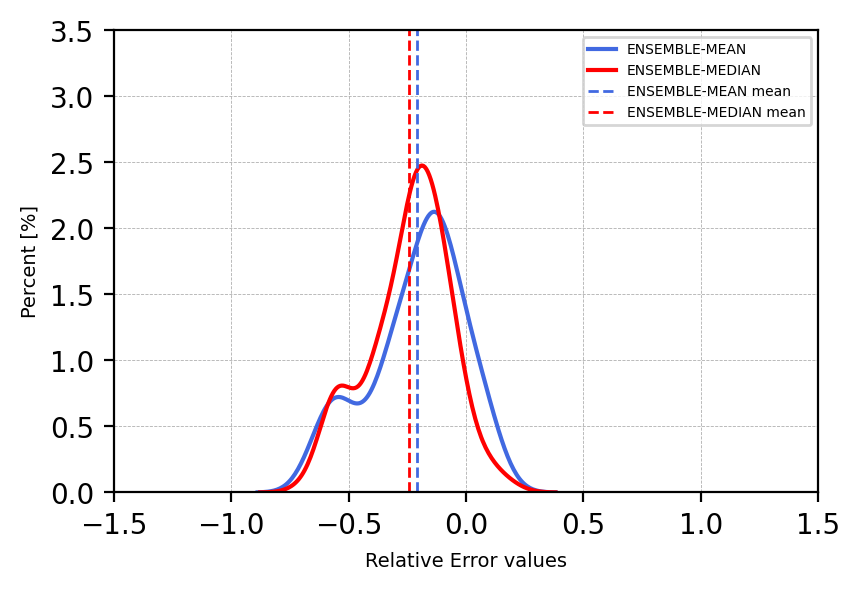

In [99]:
fig = plt.figure(figsize=(10,3),dpi=200)
gs = gridspec.GridSpec(1,2)

# =========================================================================================================================
ax1 = plt.subplot(gs[0, 0])

sns.kdeplot(IMERG_MEAN_QEs,color=colors[0],cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-MEAN')
sns.kdeplot(IMERG_MEDI_QEd,color=colors[1], linestyle='-',cumulative=False,fill=False,multiple="stack",ax=ax1,label=f'ENSEMBLE-MEDIAN')

ax1.axvline(np.mean(IMERG_MEAN_QEs),color=colors[0],linestyle='--',linewidth=1, label='ENSEMBLE-MEAN mean')
ax1.axvline(np.mean(IMERG_MEDI_QEd),color=colors[1],linestyle='--',linewidth=1, label='ENSEMBLE-MEDIAN mean')

ax1.set_ylabel('Percent [%]',fontsize=7)
ax1.set_xlabel('Relative Error values',fontsize=7)
ax1.legend(fontsize=5, loc=0, ncol=1)
ax1.grid(linewidth=0.3, linestyle='--')
ax1.set_xlim(-1.5,1.5)
ax1.set_ylim(0,3.5)